<h1> Primer Experimento </h1>

El siguiente código descarga datos actuales de la enfermedad los almacena en archivos csv e intenta ajustar los parametros de un modelo SIRD a los datos.

**Problema 1:** En la base de datos de internet no hay datos de Estados Unidos.

**Problema 2:** Todavía el ajuste no encuentra el óptimo. Desconozco la causa, a ojo se encuentra mejores elecciones que las encontradas por el programa.

**Problema 3:** Mas del proceso de modelización. Las soluciones del modelo SIRD parece tener una forma que no se corresponde con los datos de la realidad. En el sentido que la duración de la epidemia parece más corta en los modelos.

In [1]:
import numpy as np
from scipy.integrate import odeint 
import matplotlib.pyplot as plt

<h2> Buscando datos de la enfermedad </h2>

Sitio: https://data.humdata.org/dataset/novel-coronavirus-2019-ncov-cases

In [2]:
import requests

In [3]:
################################################################
###  Descarga datos actuales de internet  desde John Hopskins###
####  Cambiar la variable MiDirectorio con el directorio que se desaea trabajar

MiDirectorio='/home/fernando/fer/Investigación/Trabajo en curso/corona/'


urlb='https://data.humdata.org/hxlproxy/api/data-preview.csv?url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2F'
url1 = 'time_series_covid19_confirmed_global.csv&filename=time_series_covid19_confirmed_global.csv'
url2 = 'time_series_covid19_deaths_global.csv&filename=time_series_covid19_deaths_global.csv'
url3 = 'time_series_covid19_recovered_global.csv&filename=time_series_covid19_recovered_global.csv'


myfile = requests.get(urlb+url1)
open(MiDirectorio+'DataConfirmados.csv', 'wb').write(myfile.content)

myfile = requests.get(urlb+url2)
open(MiDirectorio+'DataMuertos.csv', 'wb').write(myfile.content)

myfile = requests.get(urlb+url3)
open(MiDirectorio+'DataRecuperados.csv', 'wb').write(myfile.content)

In [2]:
############Para leer datos descargados
import csv

In [35]:

### Los primeros 4 items de la fila son vacio,
### nombre del país, lat, long. No los usamos
### OJO: en los datos de la tabla hay valores acumulados de infectados, en los modelos
### cuentan los  infectados activos 
### Infectados Activos= Infectados Acumulados-(muertos+recuperados)

### S_data,I_data,M_data,R_data=ExtraerDatos(IndPais,Poblacion)
### IndPais = Fila del pais-región
### Poblacion=Total de habitantes
### S_data,I_data,M_data,R_data Datos de Susceptibles, infecciosos, muertes y recuperados


def ExtraerDatos(IndPais,Poblacion):
    ListI=[]
    with open('DataConfirmados.csv') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            ListI.append(row)
    ListM=[]
    with open('DataMuertos.csv') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            ListM.append(row)
    ListR=[]
    with open('DataRecuperados.csv') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            ListR.append(row)
    I_data_acum=np.array([float(i) for i in ListI[IndPais][5:]])
    M_data=np.array([float(i) for i in ListM[IndPais][5:]])
    R_data=np.array([float(i) for i in ListR[IndPais][5:]])

    I_data=I_data_acum-(M_data+R_data)
    S_data=PoblacionArg-I_data_acum #S=Poblacion-Infectados Acumulados

    #Extraemos datos desde el comienzo de la epidemia
    Ind=I_data_acum>0
    I_data_acum=I_data_acum[Ind]
    I_data=I_data[Ind]
    M_data=M_data[Ind]
    R_data=R_data[Ind]
    S_data=S_data[Ind]
    return S_data,I_data,M_data,R_data,I_data_acum

### Argentina es la fila 7 de las tablas 
PoblacionArg=44.49e6  #Segun wikipedia
IndArg=7

S_data,I_data,M_data,R_data,I_data_acum=ExtraerDatos(IndArg,PoblacionArg)


In [37]:
plt.plot(I_data,'^',M_data,'p',R_data,'o',I_data_acum,'*')

<h2> Modelo SIRD </h2>

<b> Bibliografía </b>

[BCF2019] "Mathematical Models in Epidemiology", Fred Brauer and Carlos Castillo-Chavez and Zhilan Feng, ISBN: 978-14-9399-828-9, Springer Nature,2019.

**Modelo**

SIRD Susceptibles-Infectados-Recuperados y Muertos por la enfermedad
ver sección 2.5 de [BCF2019]

$$
\begin{aligned}
&S^{\prime}=-\beta S I\\
&I^{\prime}=\beta S I-(\alpha+d) I\\
&R^{\prime}=\alpha I
\end{aligned}
$$

$$\begin{aligned}
\frac{1}{\alpha}&=\text{periodo infecciosidad medio}\\
\beta&=\text{cantidad de contactos por individuo por unidad de tiempo}\\
d&=\text{tasa de mortalidad}\\
\mathcal{R}_0&=\frac{\beta N}{\alpha+d}=\text{número reproducción básico}\\
            &=\text{Cantidad infecciones a lo largo de la vida de}\\
            &\text{un infeccioso dentro de una población de sólo susceptibles}\\
\end{aligned}
$$


Sólo es necesario modelar las primeras dos ecuaciones

In [42]:
def SIRD(Y,t,alpha,beta,d):
    S,I=Y
    dSdt=-beta*S*I
    dIdt=beta*S*I-(alpha+d)*I
    return dSdt,dIdt
####### Resolvemos el modelos
def ModeTeor(t,alpha,beta,d,y0):
    sol = odeint(SIRD,y0 ,t, args=(alpha,beta,d))
    return sol

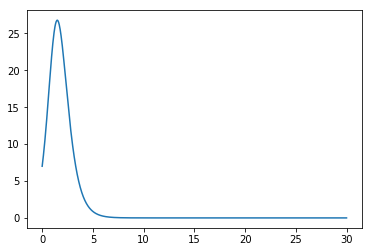

In [6]:
##########Ejemplo################
########## Plaga Eyam, peste bubónica ver seccion 2.4 de [BCF2019]
####alpha=2.73, beta=0.017, d=0
##En realidad hay defiunsiones, se computan con R

Y0=[254,7]
t = np.linspace(0,30, 1000)
argus=(2.73, 0.017,0)

sol = odeint(SIRD,Y0 ,t, args=argus)
S,I=sol[:,0],sol[:,1]
plt.plot(t,I)
plt.show()

<h2> Ajuste de los parámetros </h2>

Usaremos el submódulo de optimizacion de la librería SciPy

In [7]:
import scipy.optimize


In [43]:
def HallarParametros(t,S_data,I_data,Poblacion,rangos):
    def error_Mod(param):
        alpha,R0,d=param
        beta=(alpha+d)*R0/Poblacion
        y0=S_data[0],I_data[0] #Condicion Inicial
        Sol=ModeTeor(t,alpha,beta,d,y0)
        I=Sol[:,1]
        S=Sol[:,0]
        return max(np.abs(I_data-I))#+max(np.abs(S_data-S))

    ## Usaremos la búsqueda de un mínimo global mediate fuerzar bruta, 
    ## Busqueda en todo el rango

    
    para_opt=scipy.optimize.brute(error_Mod,rangos,finish=None)
    #para_opt= scipy.optimize.basinhopping(error_Mod, (1/30.0,2.0,.02))
    #para_opt= scipy.optimize.minimize(error_Mod,(1/30.0,2.0,.02),method='L-BFGS-B', bounds=rangos)
    return para_opt






<h2> Experimento 1. Argentina </h2>

In [44]:
### Argentina es la fila 7 de las tablas 
PoblacionArg=44.49e6  #Segun wikipedia
IndArg=7
S_data,I_data,M_data,R_data,I_data_acum=ExtraerDatos(IndArg,PoblacionArg)   
t=np.arange(0,np.shape(I_data)[0],1)
#rangos = (slice(1/30.0,1/5.0,0.001), slice(1, 4, 0.1), slice(0.001,0.01,.001))
rangos=(1.0/25.0,1/5.0), (1.0, 4.0), (0.001,0.01)
para_opt=HallarParametros(t,S_data,I_data,PoblacionArg,rangos)
para_opt

array([0.06526316, 3.05263158, 0.00905263])

1188.8164623667794

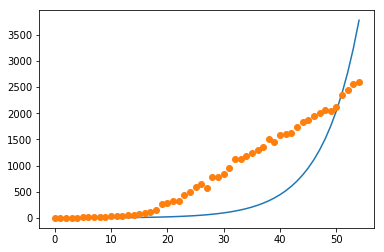

In [48]:
alpha,R0,d=para_opt
beta=R0/PoblacionArg*(alpha+d)
y0=S_data[0],I_data[0] #Condicion Inicial
Sol=ModeTeor(t, alpha,beta,d,y0)
I=Sol[:,1]
S=Sol[:,0]
plt.plot(t,I ,t,I_data,'o')
max(np.abs(I_data-I))

<h2> Conclusiones </h2>

El ajuste es muy malo, el valor de $\alpha\approx .2$ es poco realista. **El modelo no se ajusta a la observación**

Pareciera que el modelo ajusta mejor desde el día cero hasta el comienzo de la cuarentena.

Analizando otros países también descubrí que el algorítmo en realidad no está encontrando los parámetros óptimos.
